In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import math

In [2]:
comp_data = Path("/kaggle/input/MABe-mouse-behavior-detection")
comp_annotations = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")
comp_tracking = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")
for dir in comp_data.iterdir():
    print(dir)

/kaggle/input/MABe-mouse-behavior-detection/sample_submission.csv
/kaggle/input/MABe-mouse-behavior-detection/test_tracking
/kaggle/input/MABe-mouse-behavior-detection/train_annotation
/kaggle/input/MABe-mouse-behavior-detection/train.csv
/kaggle/input/MABe-mouse-behavior-detection/test.csv
/kaggle/input/MABe-mouse-behavior-detection/train_tracking


In [3]:
def count_columns(input_dir):
    column_counts = Counter()
    tracking_files = list(input_dir.rglob("*.parquet"))
    N = 15
    for f in tqdm(tracking_files[:N], desc="Counting columns"):
        try: # Tries to read in that file and updatet the column count appropriately
            df = pd.read_parquet(f, columns=None)
            column_counts.update(df.columns)
        except Exception as e:
            print(f"Error reading {f.name}: {e}")
    
    # Convert to dictionary
    column_counts_dict = dict(column_counts)
    
    # Sort by frequency (most common first)
    column_counts_sorted = dict(sorted(column_counts_dict.items(), key=lambda x: x[1], reverse=True))
    
    print(f"Found {len(column_counts_sorted)} unique column names.")
    for col, count in list(column_counts_sorted.items())[:20]:
        print(f"{col}: {count}")

count_columns(comp_tracking)

Counting columns:   0%|          | 0/15 [00:00<?, ?it/s]

Found 5 unique column names.
video_frame: 15
mouse_id: 15
bodypart: 15
x: 15
y: 15


In [4]:
count_columns(Path("/kaggle/input/fixed-merged-files/annotated_fixed"))

Counting columns:   0%|          | 0/15 [00:00<?, ?it/s]

Found 63 unique column names.
lateral_left_y: 15
tail_middle_1_y: 15
hindpaw_right_x: 15
lateral_left_x: 15
body_center_x: 15
headpiece_bottombackleft_x: 15
spine_1_x: 15
hip_right_y: 15
tail_middle_2_x: 15
ear_left_x: 15
headpiece_topbackright_x: 15
headpiece_topfrontleft_y: 15
neck_x: 15
nose_x: 15
spine_2_x: 15
headpiece_topfrontleft_x: 15
tail_midpoint_x: 15
headpiece_bottombackleft_y: 15
tail_base_y: 15
headpiece_bottomfrontright_x: 15


In [5]:
count_columns(Path("/kaggle/input/fixed-merged-files/annotated_core"))

Counting columns:   0%|          | 0/15 [00:00<?, ?it/s]

Found 11 unique column names.
ear_left_x: 15
ear_left_y: 15
ear_right_x: 15
ear_right_y: 15
tail_base_x: 15
tail_base_y: 15
mouse_id: 15
video_frame: 15
agent_id: 15
target_id: 15
action: 15


In [6]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

comp_tracking = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")
tracking_files = list(comp_tracking.rglob("*.parquet"))

unique_columns = set()
bodypart_counts = Counter()  # to count how many files each bodypart appears in
N = 20  # adjust as needed

# Loop through a subset (or all) of the files
for f in tqdm(tracking_files[::], desc="Analyzing files"):  # can limit to first N for testing
    try:
        df = pd.read_parquet(f)
        unique_columns.update(df.columns)
        
        # Only collect unique entries from 'bodypart' if that column exists
        if 'bodypart' in df.columns:
            bodyparts_in_file = df['bodypart'].dropna().unique()
            bodypart_counts.update(bodyparts_in_file)
            
    except Exception as e:
        print(f"Error reading {f.name}: {e}")

# Sort by most frequent bodyparts
bodypart_counts_sorted = dict(sorted(bodypart_counts.items(), key=lambda x: x[1], reverse=True))

# Print column names
print(f"Found {len(unique_columns)} unique column names:")
for col in sorted(unique_columns):
    print(f"- {col}")

# Print bodyparts and frequencies
print(f"\nFound {len(bodypart_counts_sorted)} unique bodyparts:")
for bp, count in bodypart_counts_sorted.items():
    print(f"{bp}: in {count} files")



Analyzing files:   0%|          | 0/8789 [00:00<?, ?it/s]

Found 5 unique column names:
- bodypart
- mouse_id
- video_frame
- x
- y

Found 29 unique bodyparts:
ear_left: in 8789 files
ear_right: in 8789 files
tail_base: in 8789 files
nose: in 8772 files
neck: in 8577 files
body_center: in 8114 files
tail_tip: in 8030 files
tail_midpoint: in 7943 files
forepaw_left: in 7926 files
forepaw_right: in 7926 files
hindpaw_left: in 7926 files
hindpaw_right: in 7926 files
hip_left: in 655 files
hip_right: in 655 files
lateral_left: in 169 files
lateral_right: in 169 files
spine_1: in 21 files
spine_2: in 21 files
tail_middle_1: in 21 files
tail_middle_2: in 21 files
head: in 17 files
headpiece_bottombackleft: in 7 files
headpiece_bottombackright: in 7 files
headpiece_bottomfrontright: in 7 files
headpiece_topbackleft: in 7 files
headpiece_topbackright: in 7 files
headpiece_topfrontleft: in 7 files
headpiece_topfrontright: in 7 files
headpiece_bottomfrontleft: in 7 files


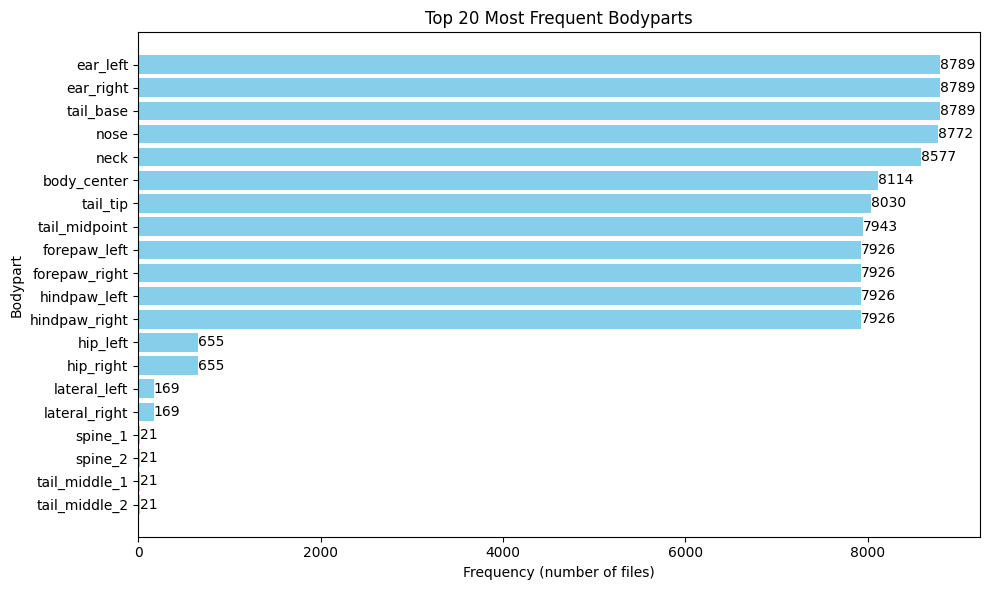

In [7]:
import matplotlib.pyplot as plt
'''
A bar plot of the most frequent appearing body-parts tracked by the number of files they appear in
'''
# Prepare data
top_n = 20
bodyparts = list(bodypart_counts_sorted.keys())[:top_n][::-1]
counts = list(bodypart_counts_sorted.values())[:top_n][::-1]

plt.figure(figsize=(10, 6))
bars = plt.barh(bodyparts, counts, color='skyblue')

# Add labels outside the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             str(count), va='center', ha='left', fontsize=10, color='black')

plt.xlabel("Frequency (number of files)")
plt.ylabel("Bodypart")
plt.title(f"Top {top_n} Most Frequent Bodyparts")
plt.tight_layout()
plt.show()


In [8]:
'''
A look at the basic structure of the annotation files by taking a peek at one specific file
'''
root_dir = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation/AdaptableSnail/1212811043.parquet")
df = pd.read_parquet(root_dir)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   agent_id     370 non-null    int8  
 1   target_id    370 non-null    int8  
 2   action       370 non-null    object
 3   start_frame  370 non-null    int32 
 4   stop_frame   370 non-null    int32 
dtypes: int32(2), int8(2), object(1)
memory usage: 6.6+ KB
None
   agent_id  target_id action  start_frame  stop_frame
0         1          3  chase            2          54
1         1          3  chase          128         234
2         3          2  avoid          324         342
3         3          1  avoid          324         342
4         1          2  chase          942        1052


In [9]:
import pandas as pd
from pathlib import Path
from collections import defaultdict
import math

'''
Calculates some statistics about the actions, how often they appear, the average duration (in frames) of each action, the min duration (in frames) and the max durataion (in frames)
'''

# -----------------------------
# CONFIG: path to annotation directory
# -----------------------------
root_dir = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")


# -----------------------------
# FUNCTION: find all parquet files
# -----------------------------
def find_parquet_files(root: Path):
    """Return a list of all parquet files under the root directory."""
    return list(root.rglob("*.parquet"))

# -----------------------------
# FUNCTION: summarize annotations
# -----------------------------
def summarize_annotations(parquet_files):
    """
    Takes as input a list of parquet files, and for each one calculates:
    - Count of each action
    - Durations (stop_frame - start_frame + 1)
    Missing durations are recorded as NaN.
    
    Returns a pandas DataFrame with one row per action occurrence.
    """
    records = []  # list to store all action occurrences

    for file in parquet_files:
        df = pd.read_parquet(file)

        # Check required columns
        required_cols = ['action', 'start_frame', 'stop_frame']
        for col in required_cols:
            if col not in df.columns:
                # If missing, create column filled with NaN
                df[col] = float('nan')

        # Iterate over each row (action occurrence)
        for _, row in df.iterrows():
            action = row['action']
            start = row['start_frame']
            stop = row['stop_frame']

            # Calculate duration if possible, else NaN
            if pd.notna(start) and pd.notna(stop):
                duration = stop - start + 1
            else:
                duration = float('nan')

            records.append({
                'action': action,
                'start_frame': start,
                'stop_frame': stop,
                'duration': duration
            })

    # Convert to DataFrame
    summary_df = pd.DataFrame(records)

    # Aggregate per action for counts and duration stats
    agg_df = summary_df.groupby('action').agg(
        count=('action', 'count'),
        mean_duration=('duration', 'mean'),
        min_duration=('duration', 'min'),
        max_duration=('duration', 'max')
    ).reset_index()

    # Sort by most frequent actions
    agg_df = agg_df.sort_values('count', ascending=False).reset_index(drop=True)

    return summary_df, agg_df

# -----------------------------
# RUN THE EDA
# -----------------------------
parquet_files = find_parquet_files(root_dir)
print(f"Found {len(parquet_files)} parquet files.")

# Get both the raw action-level DataFrame and the aggregated summary
raw_df, summary_df = summarize_annotations(parquet_files)

# -----------------------------
# VIEW RESULTS
# -----------------------------
print("Aggregated action summary:")
print(summary_df)

print("\nRaw action occurrences (first 5 rows):")
print(raw_df.head())
print(raw_df.info())


Found 847 parquet files.
Aggregated action summary:
             action  count  mean_duration  min_duration  max_duration
0             sniff  37837      57.838280             1          6114
1      sniffgenital   7862      90.535869             3         13907
2            attack   7462      70.534977             1          3870
3              rear   4408      53.379537             3          2480
4         sniffbody   3518      30.355884             1           648
5          approach   3270      27.289908             1           685
6         sniffface   2811      26.445393             3           709
7             mount   2747     104.724427             1          3674
8            escape   2071      44.604056             3          1116
9   reciprocalsniff   1492      28.266756             3           433
10           defend   1409      64.862314             2          3161
11        selfgroom   1356      61.295723             4           838
12              dig   1127      70.893

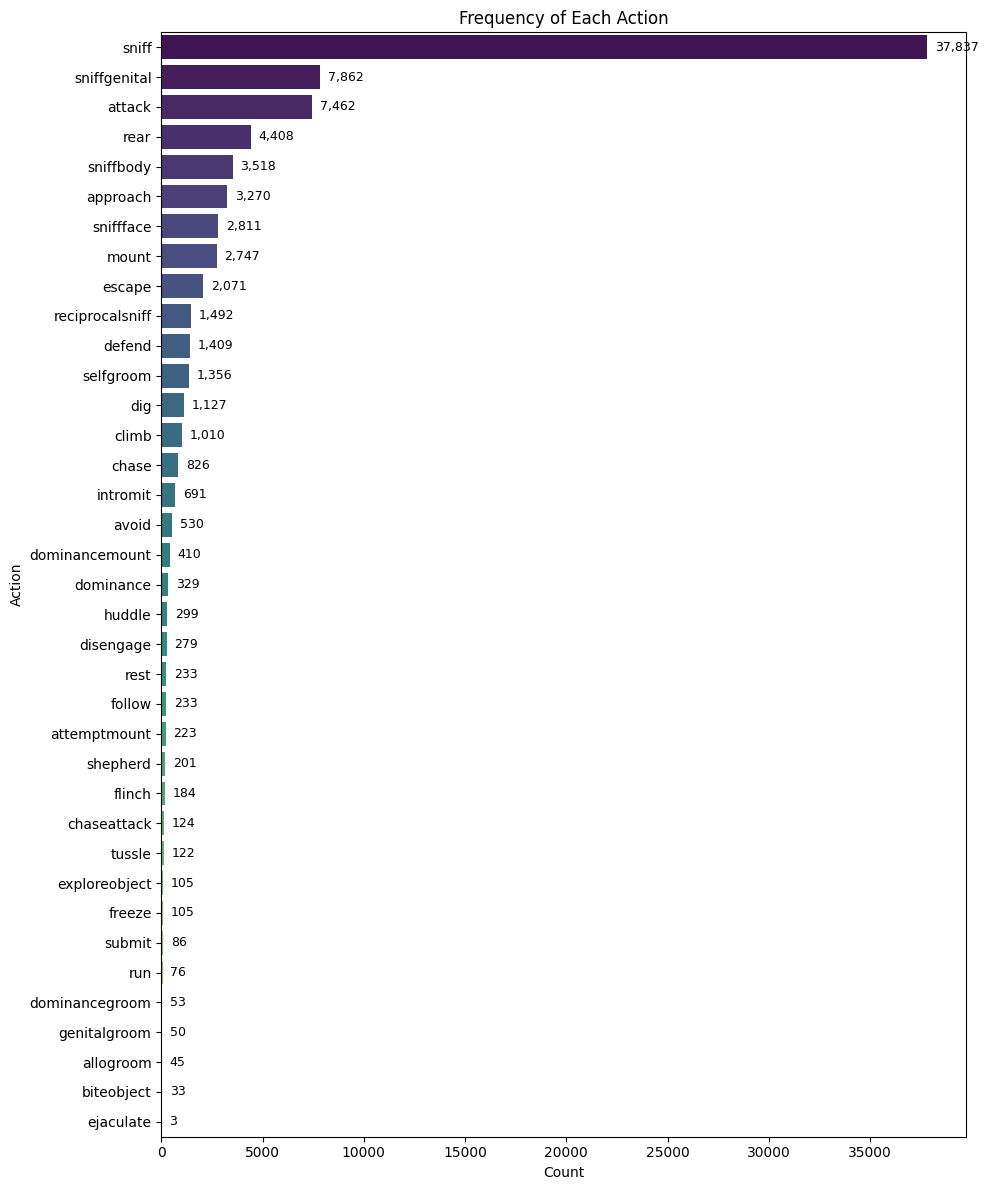

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------
# FUNCTION: horizontal bar plot of action count frequency
# -----------------------------
def plot_action_counts(summary_df):
    """
    Create a horizontal bar plot showing the frequency of each action.
    Features:
        - Bars sorted ascending so largest counts appear at the top
        - Numerical count label at end of each bar
        - Clear axis labels and title
    """
    
    # Sort the DataFrame by 'count' in ascending order for horizontal plotting
    # This ensures the most frequent actions are at the top of the plot
    summary_df_sorted = summary_df.sort_values('count', ascending=False)
    
    # Set up the figure size for readability
    plt.figure(figsize=(10, 12))
    
    # Create horizontal bar plot
    ax = sns.barplot(
        data=summary_df_sorted,
        y='action',   # Action labels on Y-axis
        x='count',    # Counts on X-axis
        palette="viridis"  # Color palette for bars
    )
    
    # Add numerical count labels at the end of each bar for readability
    for i, row in enumerate(summary_df_sorted.itertuples()):
        ax.text(
            row.count + max(summary_df_sorted['count'])*0.01,  # Small offset from bar end
            i,  # Vertical position (matches the bar)
            f"{row.count:,}",  # Format with commas
            va='center',  # Vertically center the text with the bar
            fontsize=9
        )
    
    # Set X and Y axis labels
    plt.xlabel("Count")
    plt.ylabel("Action")
    
    # Add plot title
    plt.title("Frequency of Each Action")
    
    # Automatically adjust subplot params for better layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


plot_action_counts(summary_df) # Calls the function to display it

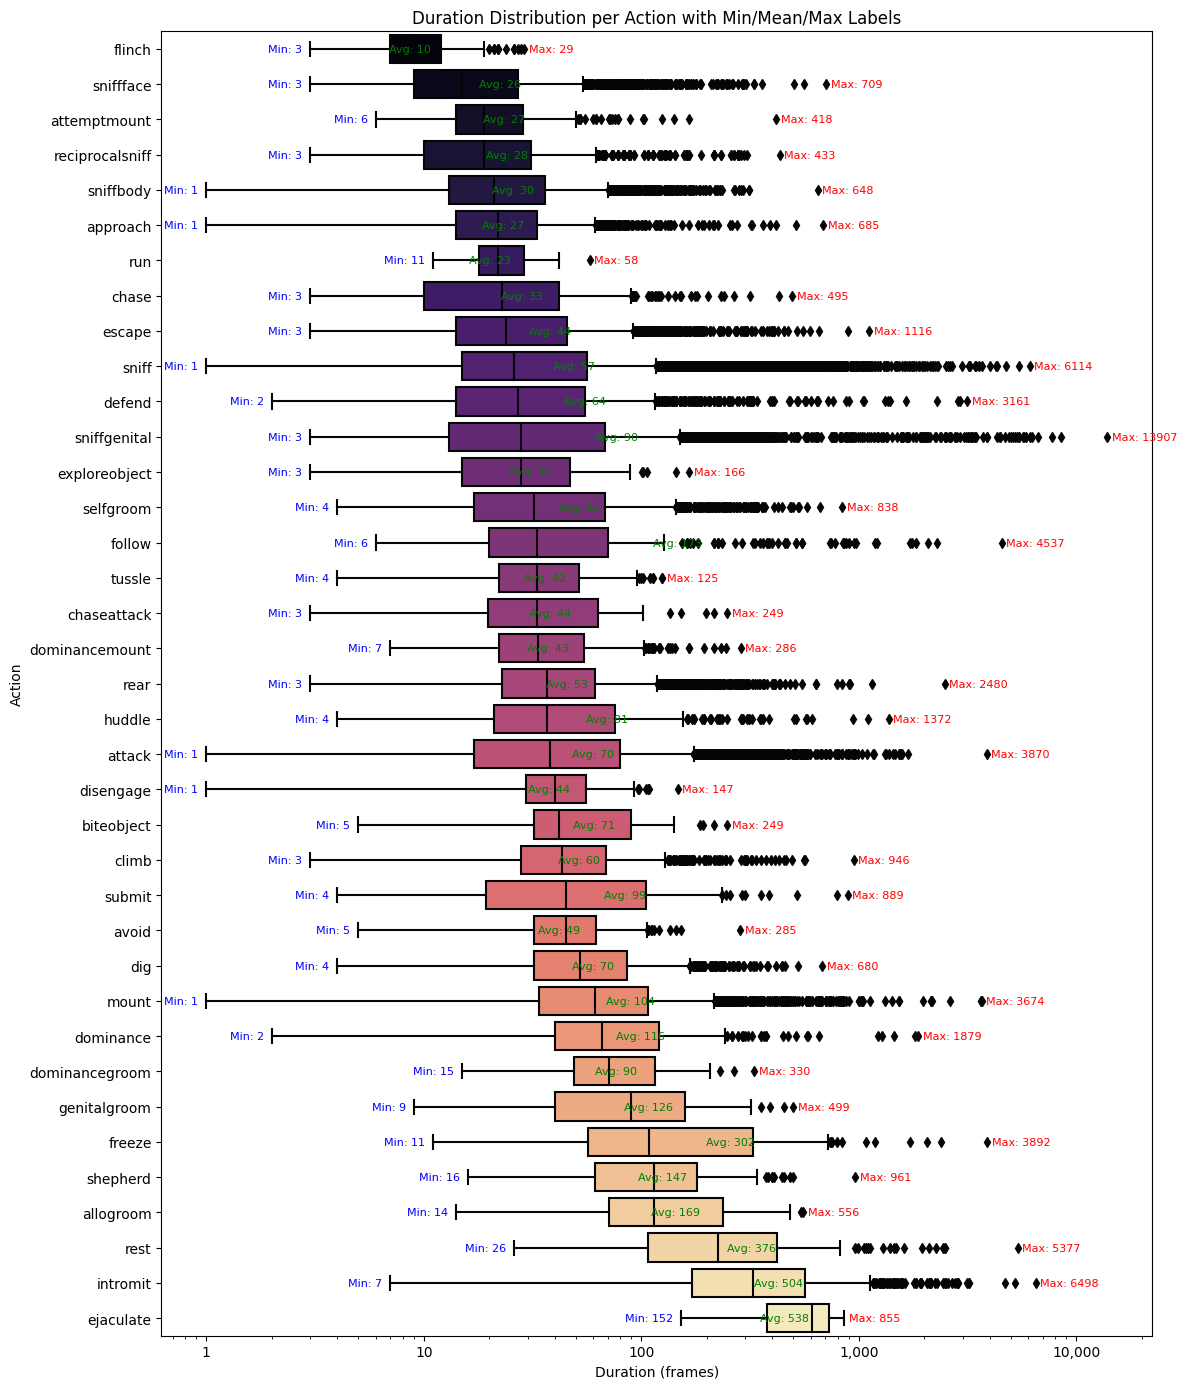

In [11]:


import matplotlib.ticker as mtick

# -----------------------------
# FUNCTION: horizontal boxplot of aggregate action durations with adjusted min/mean/max labels
# -----------------------------
def plot_action_durations(raw_df, summary_df, log_scale=True):
    """
    Horizontal boxplot of action durations with min, mean, and max annotations.
    Label positions are adjusted to avoid overlapping the boxplot whiskers.

    Parameters:
        raw_df: DataFrame with columns ['action', 'duration']
        summary_df: DataFrame with aggregated stats per action ('min_duration', 'mean_duration', 'max_duration')
        log_scale: bool, whether to use log scale on X-axis
    """
    
    # -----------------------------
    # Sort actions by median duration for plotting
    # -----------------------------
    median_durations = raw_df.groupby('action')['duration'].median().sort_values()
    sorted_actions = median_durations.index.tolist()
    
    # -----------------------------
    # Create figure
    # -----------------------------
    plt.figure(figsize=(12, 14))
    
    # -----------------------------
    # Horizontal boxplot
    # -----------------------------
    ax = sns.boxplot(
        data=raw_df,
        y='action',
        x='duration',
        order=sorted_actions,
        palette="magma"
    )
    
    # -----------------------------
    # Apply log scale if needed
    # -----------------------------
    if log_scale:
        plt.xscale('log')
    
    # -----------------------------
    # Axis labels and title
    # -----------------------------
    plt.xlabel("Duration (frames)")
    plt.ylabel("Action")
    plt.title("Duration Distribution per Action with Min/Mean/Max Labels")
    
    # -----------------------------
    # Format X-axis tick labels
    # -----------------------------
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
    
    # -----------------------------
    # Annotate min, mean, max for each action with adjusted positions
    # -----------------------------
    for i, action in enumerate(sorted_actions):
        stats = summary_df[summary_df['action'] == action].iloc[0]
        min_val = stats['min_duration']
        mean_val = stats['mean_duration']
        max_val = stats['max_duration']
        
        # Multiplicative offsets for log-scale-friendly spacing
        offset_min = 0.92   # push min left by ~15%
        offset_mean = 0.85  # move mean slightly left to be fully inside box
        offset_max = 1.05   # push max right by ~5%
        
        # Annotate min (left of whisker)
        ax.text(min_val * offset_min, i, f"Min: {int(min_val)}", va='center', ha='right', fontsize=8, color='blue')
        # Annotate mean (inside the box)
        ax.text(mean_val * offset_mean, i, f"Avg: {int(mean_val)}", va='center', ha='center', fontsize=8, color='green')
        # Annotate max (right of whisker)
        ax.text(max_val * offset_max, i, f"Max: {int(max_val)}", va='center', ha='left', fontsize=8, color='red')
    
    # -----------------------------
    # Adjust layout and show plot
    # -----------------------------
    plt.tight_layout()
    plt.show()


plot_action_durations(raw_df, summary_df) # Calls the box plot function

In [12]:
import pandas as pd
from pathlib import Path

# -----------------------------
# FUNCTION: summarize per-video action statistics
# -----------------------------
def summarize_videos(parquet_dir):
    """
    Reads all annotation parquet files in subdirectories and computes per-video summary statistics.

    Parameters:
        parquet_dir: str or Path, root directory containing subdirectories with parquet files.

    Returns:
        video_summary_df: DataFrame with one row per video, including:
            - video_id: filename without extension
            - total_actions: total number of actions in the video
            - unique_actions: number of different action types
            - mean_duration: mean action duration in frames
            - min_duration: minimum action duration
            - max_duration: maximum action duration
            - action_counts: dictionary of counts per action
    """

    # Ensure Path object for consistent file handling
    root = Path(parquet_dir)
    
    # Find all parquet files recursively
    parquet_files = list(root.rglob("*.parquet"))
    
    # Warn if no files found
    if not parquet_files:
        print("Found 0 parquet files.")
        return pd.DataFrame()  # Return empty DataFrame
    
    # List to store per-video summaries
    summaries = []

    # -----------------------------
    # Iterate over each parquet file (i.e., each video)
    # -----------------------------
    for file_path in parquet_files:
        # Extract video ID from filename (without extension)
        video_id = file_path.stem
        
        # Read parquet file into DataFrame
        try:
            df = pd.read_parquet(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue  # Skip file if reading fails
        
        # Skip if DataFrame is empty
        if df.empty:
            continue
        
        # -----------------------------
        # Compute per-video statistics
        # -----------------------------
        total_actions = len(df)
        unique_actions = df['action'].nunique() if 'action' in df.columns else 0
        
        # Compute durations (stop_frame - start_frame)
        if {'start_frame', 'stop_frame'}.issubset(df.columns):
            df['duration'] = df['stop_frame'] - df['start_frame']
            mean_duration = df['duration'].mean()
            min_duration = df['duration'].min()
            max_duration = df['duration'].max()
        else:
            # Use NaN if frames missing
            mean_duration = min_duration = max_duration = float('nan')
        
        # Count occurrences per action
        if 'action' in df.columns:
            action_counts = df['action'].value_counts().to_dict()
        else:
            action_counts = {}
        
        # Append summary for this video
        summaries.append({
            'video_id': video_id,
            'total_actions': total_actions,
            'unique_actions': unique_actions,
            'mean_duration': mean_duration,
            'min_duration': min_duration,
            'max_duration': max_duration,
            'action_counts': action_counts
        })
    
    # -----------------------------
    # Combine all video summaries into a single DataFrame
    # -----------------------------
    video_summary_df = pd.DataFrame(summaries)
    
    # Sort by total actions descending for convenience
    video_summary_df.sort_values('total_actions', ascending=False, inplace=True)
    
    # Reset index
    video_summary_df.reset_index(drop=True, inplace=True)
    
    return video_summary_df


video_summary = summarize_videos(comp_annotations) # Calls the function to generate the per-video-summary dataframe

In [13]:
# -----------------------------
# FUNCTION: histogram of total actions per video with value labels
# -----------------------------
def plot_total_actions_per_video(video_summary_df):
    """
    Histogram showing distribution of total actions per video.
    Features:
        - Dynamic bin sizing using Freedman–Diaconis rule
        - Annotated mean and median lines
        - Count values displayed above each bar (excluding zero-count bars)
        - Cleanly formatted tick labels
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.ticker as mtick

    plt.figure(figsize=(10, 6))

    # -----------------------------
    # Determine dynamic bins
    # -----------------------------
    data = video_summary_df['total_actions']
    q25, q75 = np.percentile(data, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data) ** (-1 / 3)
    bins = int((data.max() - data.min()) / bin_width)
    bins = max(bins, 10)  # ensure at least 10 bins

    # Compute histogram manually to get counts for annotation
    counts, bin_edges = np.histogram(data, bins=bins)

    # Plot histogram as bar chart
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.bar(bin_centers, counts, width=(bin_edges[1]-bin_edges[0]), color='steelblue', edgecolor='white', alpha=0.8)

    # -----------------------------
    # Annotate each bar with its count (skip zero-count bars)
    # -----------------------------
    for x, y in zip(bin_centers, counts):
        if y > 0:
            plt.text(x, y + max(counts)*0.01, f"{y}", ha='center', va='bottom', fontsize=8)

    # -----------------------------
    # Annotate mean & median
    # -----------------------------
    mean_val = data.mean()
    median_val = data.median()
    plt.axvline(mean_val, color='red', linestyle='--', lw=1, label=f"Mean: {mean_val:.1f}")
    plt.axvline(median_val, color='green', linestyle=':', lw=1, label=f"Median: {median_val:.1f}")
    plt.legend()

    # -----------------------------
    # Axis formatting
    # -----------------------------
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
    plt.xlabel("Total Actions per Video")
    plt.ylabel("Number of Videos")
    plt.title("Distribution of Total Actions Across Videos")
    plt.tight_layout()
    plt.show()


In [14]:
# -----------------------------
# FUNCTION: horizontal barplot of mean action durations per video
# -----------------------------
def plot_mean_durations_per_video(video_summary_df, top_n=40):
    """
    Horizontal barplot of mean action durations per video.
    Sorts by mean duration, limits to top-N for clarity, and places numeric labels above bars.

    Parameters:
        video_summary_df : pd.DataFrame
            Must contain columns ['video_id', 'mean_duration']
        top_n : int, optional
            Number of top videos (by mean duration) to display for clarity
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.ticker as mtick

    # -----------------------------
    # Sort videos by mean duration and select top-N
    # -----------------------------
    sorted_videos = video_summary_df.sort_values('mean_duration', ascending=False).head(top_n)

    # Dynamically adjust plot height based on number of videos
    plt.figure(figsize=(10, max(6, top_n * 0.25)))

    # -----------------------------
    # Create horizontal barplot
    # -----------------------------
    ax = sns.barplot(
        data=sorted_videos,
        y='video_id',          # Each bar = one video
        x='mean_duration',     # Bar length = mean duration
        palette='coolwarm'     # Color scheme for visual clarity
    )

    # -----------------------------
    # Add numeric labels ABOVE the bar
    # -----------------------------
    for i, row in enumerate(sorted_videos.itertuples()):
        ax.text(
            row.mean_duration*1.023,        # X position (end of bar)
            i,                  # Y position slightly above the bar
            f"{row.mean_duration:,.1f}",  # Formatted label text
            ha='left',              # Center align horizontally
            va='center',              # Anchor text from the bottom
            fontsize=8,
            color='black'
        )

    # -----------------------------
    # Format axes and title
    # -----------------------------
    plt.xlabel("Mean Action Duration (frames)")
    plt.ylabel("Video ID")
    plt.title(f"Mean Action Duration per Video (Top {top_n})")

    # Add commas to X-axis tick labels for readability
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Tight layout ensures labels and titles fit within the figure
    plt.tight_layout()
    plt.show()


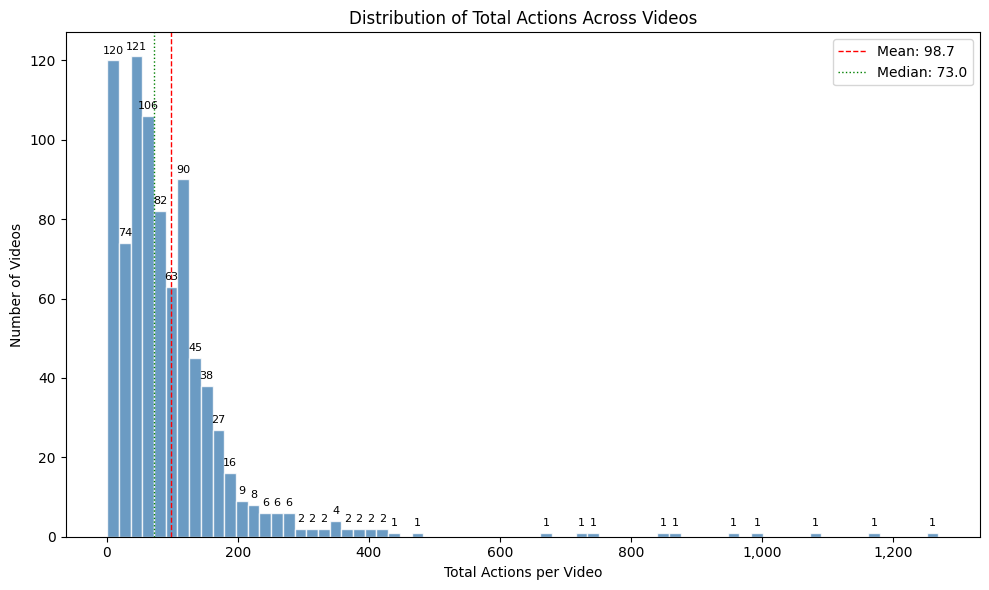

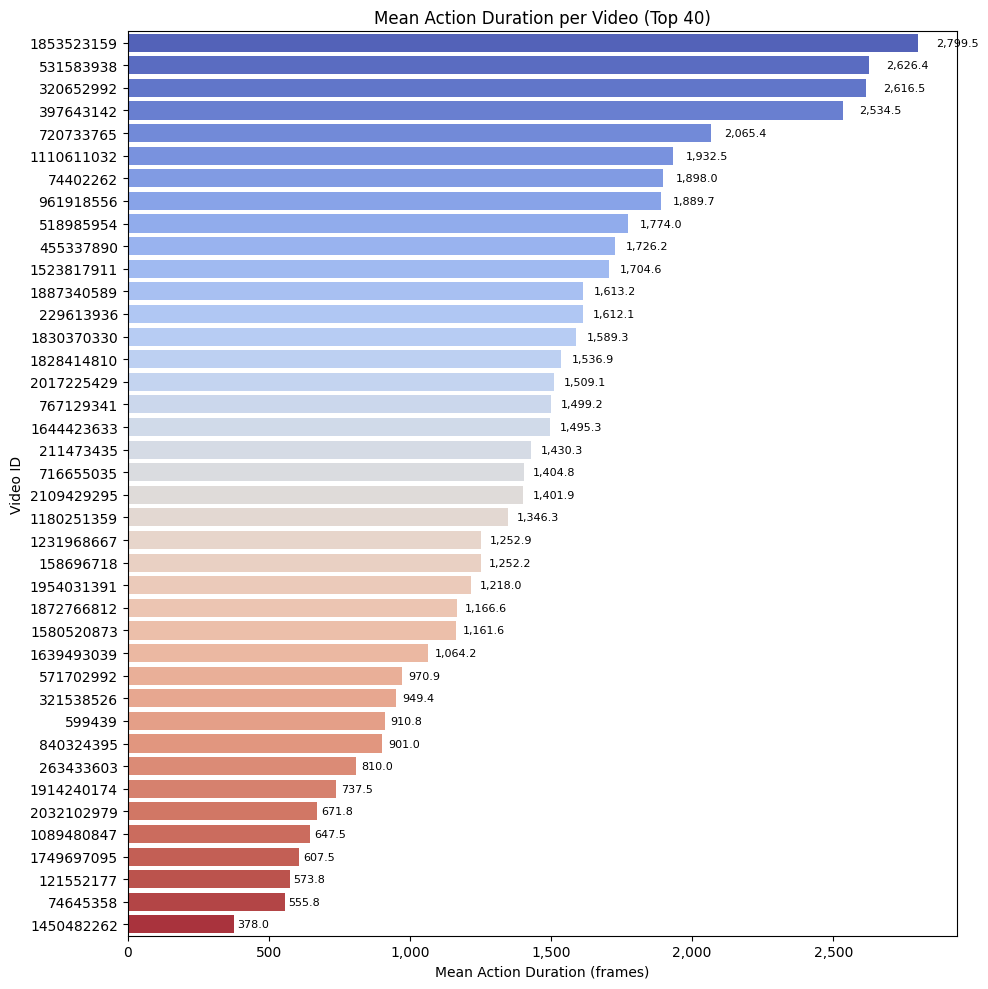

In [15]:
# -----------------------------
# FUNCTION: per-video EDA dashboard
# -----------------------------
def per_video_eda_dashboard(video_summary_df, show_hist=True, show_heatmap=True, show_mean_duration=True):
    """
    Generates a per-video exploratory data analysis dashboard.
    
    Parameters:
        video_summary_df: DataFrame returned from summarize_videos()
        show_hist: bool, whether to show histogram of total actions per video
        show_heatmap: bool, whether to show heatmap of action counts per video
        show_mean_duration: bool, whether to show horizontal barplot of mean durations per video
    """
    
    # -----------------------------
    # Histogram of total actions per video
    # -----------------------------
    if show_hist:
        plot_total_actions_per_video(video_summary_df)
   
    # -----------------------------
    # Horizontal barplot of mean action durations per video
    # -----------------------------
    if show_mean_duration:
        plot_mean_durations_per_video(video_summary_df)


per_video_eda_dashboard(video_summary) # Calls the dashboard function and passes it the video_summary. This function call will produce the per-video charts

In [16]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

# -----------------------------
# FUNCTION: summarize columns across all parquet files in a specified directory with a progress bar
# -----------------------------
def summarize_parquet_columns(input_dir):
    """
    Summarize column structure across all parquet files in a directory, with a progress bar.
    
    Parameters:
        parquet_dir: str or Path - directory containing parquet files
    
    Returns:
        column_summary_df: DataFrame with columns:
            - column_name: column name found in parquet files
            - file_count: number of files containing this column
            - null_file_count: number of files where this column had NaN values
            - percent_files_with_nulls: percentage of files containing NaNs for that column
    """
    
    parquet_dir = Path(input_dir)
    
    # List all parquet files
    file_list = list(parquet_dir.rglob("*.parquet"))
    total_files = len(file_list)
    print(f"Found {total_files} parquet files in {parquet_dir}")
    
    all_columns = []
    any_null_columns_counter = Counter()
    all_null_columns_counter = Counter()

    # -----------------------------
    # Iterate over files with progress bar
    # -----------------------------
    for file_path in tqdm(file_list, desc="Processing parquet files to count column occurrence"):
        try:
            df = pd.read_parquet(file_path)
            all_columns.extend(df.columns.tolist())

            # Count columns that contain *any* NaN values (not necessarily all NaN)
            cols_with_any_nulls = df.columns[df.isna().any()].tolist()
            any_null_columns_counter.update(cols_with_any_nulls)
            # Count columns that contain *all* NaN values
            cols_with_all_nulls = df.columns[df.isna().all()].tolist()
            all_null_columns_counter.update(cols_with_all_nulls)
            
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {e}")
    
    # Count how many files contain each column
    column_counts = Counter(all_columns)
    
    # Convert to DataFrame for easy viewing
    column_summary_df = (
        pd.DataFrame.from_dict(column_counts, orient='index', columns=['file_count'])
        .reset_index()
        .rename(columns={'index': 'column_name'})
    )
    
    # Add column for any null value in a column count
    column_summary_df["any_null_value_file_count"] = column_summary_df["column_name"].map(any_null_columns_counter).fillna(0).astype(int)
    # Add column for all null values in a column file count
    column_summary_df["all_null_values_file_count"] = column_summary_df["column_name"].map(all_null_columns_counter).fillna(0).astype(int)

    # Compute percentage of files containing any nulls for each column
    column_summary_df["percent_files_with_any_nulls"] = (
        column_summary_df["any_null_value_file_count"] / total_files * 100
    ).round(2)

    # Compute percentage of files containing all nulls for each column
    column_summary_df["percent_files_with_all_nulls"] = (
        column_summary_df["all_null_values_file_count"] / total_files * 100
    ).round(2)
    
    # Sort by percent_files_with_nulls descending
    column_summary_df = column_summary_df.sort_values(
        by="percent_files_with_any_nulls", ascending=False
    ).reset_index(drop=True)
    
    return column_summary_df


In [17]:
'''
Columns at the top show the least reliable data across all files
'''
def top_columns_missing_data(column_summary_df):
    top_n = 20
    subset = column_summary_df.head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(subset["column_name"], subset["percent_files_with_any_nulls"])
    plt.gca().invert_yaxis()
    plt.xlabel("% of files with NaNs")
    plt.title(f"Top {top_n} Columns with Missing Data")
    plt.tight_layout()
    plt.show()


In [18]:
# Helps visualize how widespread any missing data is
# If left - skewed the data is mostly clean
# If right - skewed many columns have missing data
def files_missing_data(column_summary_df):
    plt.figure(figsize=(8, 5))
    plt.hist(column_summary_df["percent_files_with_any_nulls"], bins=20, edgecolor="black")
    plt.xlabel("% of files with NaNs")
    plt.ylabel("Number of columns")
    plt.title("Distribution of Missing Data Across Columns")
    plt.show()


In [19]:
# A heat-map of columns and missing data for quick pattern comparison visually
def missing_data_heatmap(column_summary_df):
    top_cols = column_summary_df.head(20)["column_name"]
    heatmap_df = column_summary_df.set_index("column_name").loc[top_cols, ["file_count", "any_null_value_file_count"]]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_df, annot=True, cmap="YlOrRd", fmt="g")
    plt.title("Top 20 Columns: File Count vs Null Count")
    plt.show()


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_column_missingness(column_summary_df):
    """
    Creates an interpretable visualization showing how many files each column
    contains missing data in. The plot is sorted, color-coded, and annotated
    for human readability.
    """
    # Sort columns by how often they contain missing data
    df = column_summary_df.sort_values("percent_files_with_any_nulls", ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(10, max(5, len(df) * 0.25)))  # dynamic height scaling
    
    # Define colors from complete (green) to missing (red)
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    # Create bar plot
    bars = plt.barh(
        y=df["column_name"],
        width=df["any_null_value_file_count"],
        color=cmap(df["percent_files_with_any_nulls"] / 100),
        edgecolor='gray',
        alpha=0.9
    )
    
    # Labels and titles
    plt.xlabel("Number of Files Containing Any Null Values", fontsize=11)
    plt.ylabel("Column Name", fontsize=11)
    plt.title("How Often Each Column Contains Any Missing Data Across Files", fontsize=14, fontweight="bold")
    
    # Add percentage labels for clarity
    for i, (count, pct) in enumerate(zip(df["any_null_value_file_count"], df["percent_files_with_any_nulls"])):
        label = f"{pct:.1f}%" if pct > 0 else ""
        plt.text(count + 2, i, label, va="center", fontsize=9, color="dimgray")
    
    # Highlight fully missing or fully complete columns
    total_files = df["file_count"].iloc[0]
    fully_missing = df[df["any_null_value_file_count"] == total_files]
    fully_complete = df[df["any_null_value_file_count"] == 0]
    
    if len(fully_missing) > 0:
        plt.axvline(total_files, color="red", linestyle="--", alpha=0.6)
        plt.text(total_files - 5, len(df)-1, f"{len(fully_missing)} columns 100% missing",
                 color="red", fontsize=9, va="bottom", ha="right")

    if len(fully_complete) > 0:
        plt.axvline(0, color="green", linestyle="--", alpha=0.6)
        plt.text(5, len(df)-1, f"{len(fully_complete)} columns fully complete",
                 color="green", fontsize=9, va="bottom", ha="left")

    plt.tight_layout()
    plt.show()


In [21]:
def top_columns_missing_all_data(column_summary):
    """Visualize columns that are fully missing (all NaNs) across parquet files."""
    
    # Sort columns by how often they contain missing data
    df = column_summary.sort_values("percent_files_with_all_nulls", ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(10, max(5, len(df) * 0.25)))  # dynamic height scaling
    
    # Define colors from complete (green) to missing (red)
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    # Create bar plot
    bars = plt.barh(
        y=df["column_name"],
        width=df["all_null_values_file_count"],
        color=cmap(df["percent_files_with_all_nulls"] / 100),
        edgecolor='gray',
        alpha=0.9
    )
    
    # Labels and titles
    plt.xlabel("Number of Files Containing All Null Values", fontsize=11)
    plt.ylabel("Column Name", fontsize=11)
    plt.title("How Often Each Column Contains All Missing Data Across Files", fontsize=14, fontweight="bold")
    
    # Add percentage labels for clarity
    for i, (count, pct) in enumerate(zip(df["all_null_values_file_count"], df["percent_files_with_all_nulls"])):
        label = f"{pct:.1f}%" if pct > 0 else ""
        plt.text(count + 2, i, label, va="center", fontsize=9, color="dimgray")
    
    # Highlight fully missing or fully complete columns
    total_files = df["file_count"].iloc[0]
    fully_missing = df[df["all_null_values_file_count"] == total_files]
    fully_complete = df[df["all_null_values_file_count"] == 0]
    
    if len(fully_missing) > 0:
        plt.axvline(total_files, color="red", linestyle="--", alpha=0.6)
        plt.text(total_files - 5, len(df)-1, f"{len(fully_missing)} columns 100% missing",
                 color="red", fontsize=9, va="bottom", ha="right")

    if len(fully_complete) > 0:
        plt.axvline(0, color="green", linestyle="--", alpha=0.6)
        plt.text(5, len(df)-1, f"{len(fully_complete)} columns fully complete",
                 color="green", fontsize=9, va="bottom", ha="left")

    plt.tight_layout()
    plt.show()


In [22]:
# A dashboard type function to call all of the file column summary visual functions to display

def column_summary_visuals(column_summary):
    # Creates a visual to show what data is lost when increasing a threshold for completeness 
    visualize_column_missingness(column_summary)
    # A heat-map of columns and missing data for quick pattern comparison visually
    missing_data_heatmap(column_summary)
    # Helps visualize how widespread any missing data is
    # If left - skewed the data is mostly clean
    # If right - skewed many columns have missing data
    files_missing_data(column_summary)
    # Columns at the top show the least reliable data across all files
    top_columns_missing_data(column_summary)


    top_columns_missing_all_data(column_summary)


Found 8789 parquet files in /kaggle/input/MABe-mouse-behavior-detection/train_tracking


Processing parquet files to count column occurrence:   0%|          | 0/8789 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   5 non-null      object 
 1   file_count                    5 non-null      int64  
 2   any_null_value_file_count     5 non-null      int64  
 3   all_null_values_file_count    5 non-null      int64  
 4   percent_files_with_any_nulls  5 non-null      float64
 5   percent_files_with_all_nulls  5 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 372.0+ bytes
None
   column_name  file_count  any_null_value_file_count  \
0  video_frame        8789                          0   
1     mouse_id        8789                          0   
2     bodypart        8789                          0   
3            x        8789                          0   
4            y        8789                          0   

   all_null_v

/tmp/ipykernel_13/507122947.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


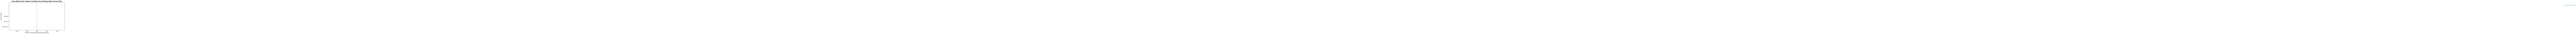

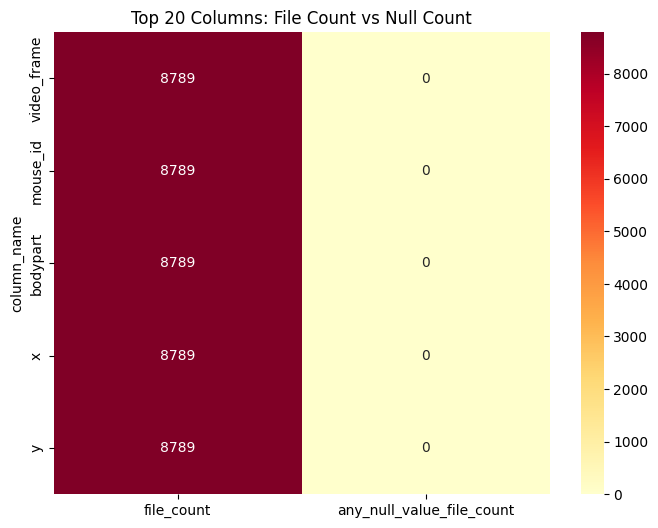

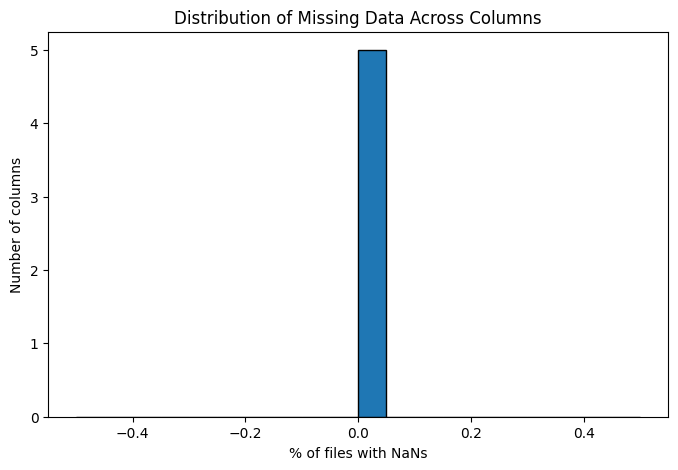

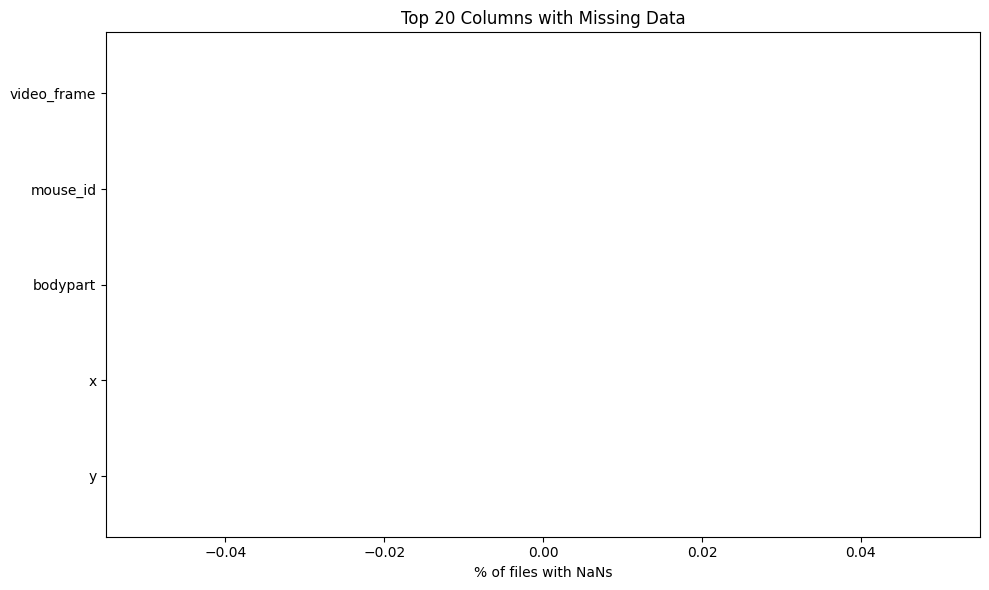

/tmp/ipykernel_13/2601261557.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


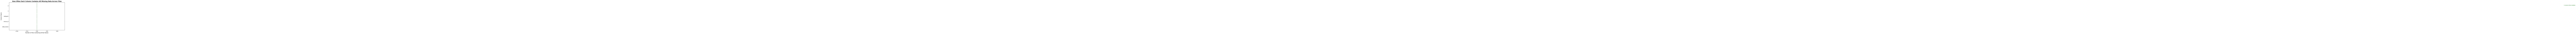

In [23]:
column_summary_df = summarize_parquet_columns("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")

print(column_summary_df.info())
print(column_summary_df.head(10))
column_summary_visuals(column_summary_df)


Found 847 parquet files in /kaggle/input/MABe-mouse-behavior-detection/train_annotation


Processing parquet files to count column occurrence:   0%|          | 0/847 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   5 non-null      object 
 1   file_count                    5 non-null      int64  
 2   any_null_value_file_count     5 non-null      int64  
 3   all_null_values_file_count    5 non-null      int64  
 4   percent_files_with_any_nulls  5 non-null      float64
 5   percent_files_with_all_nulls  5 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 372.0+ bytes
None
   column_name  file_count  any_null_value_file_count  \
0     agent_id         847                          0   
1    target_id         847                          0   
2       action         847                          0   
3  start_frame         847                          0   
4   stop_frame         847                          0   

   all_null_v

/tmp/ipykernel_13/507122947.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


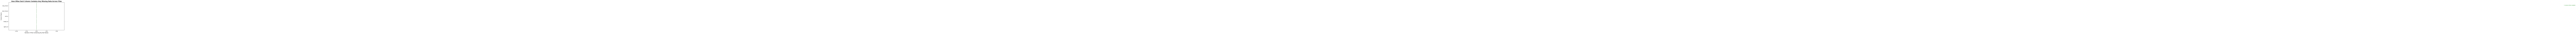

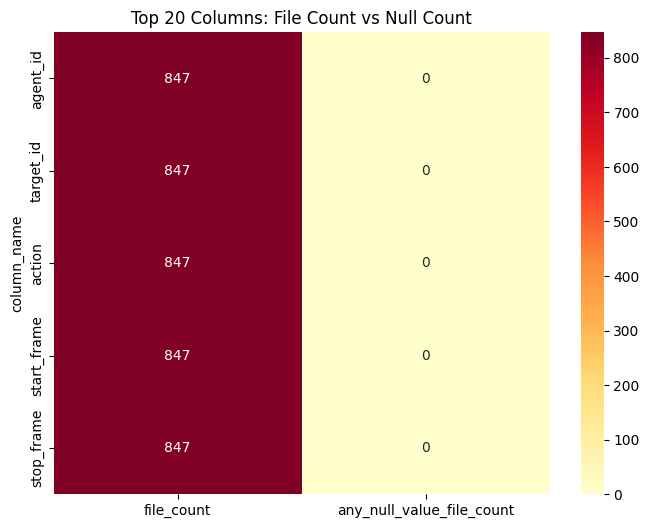

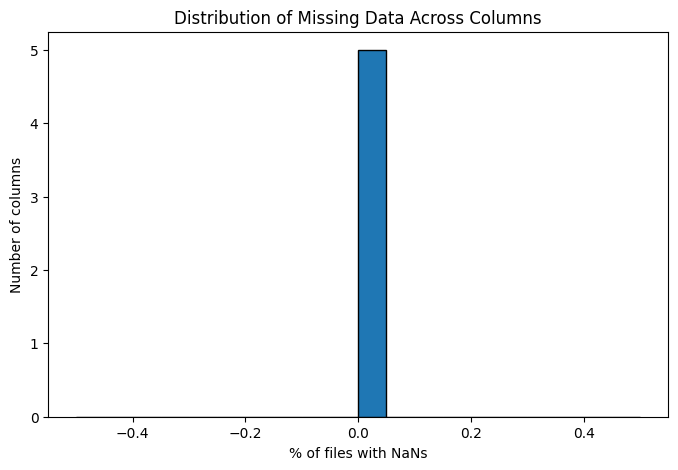

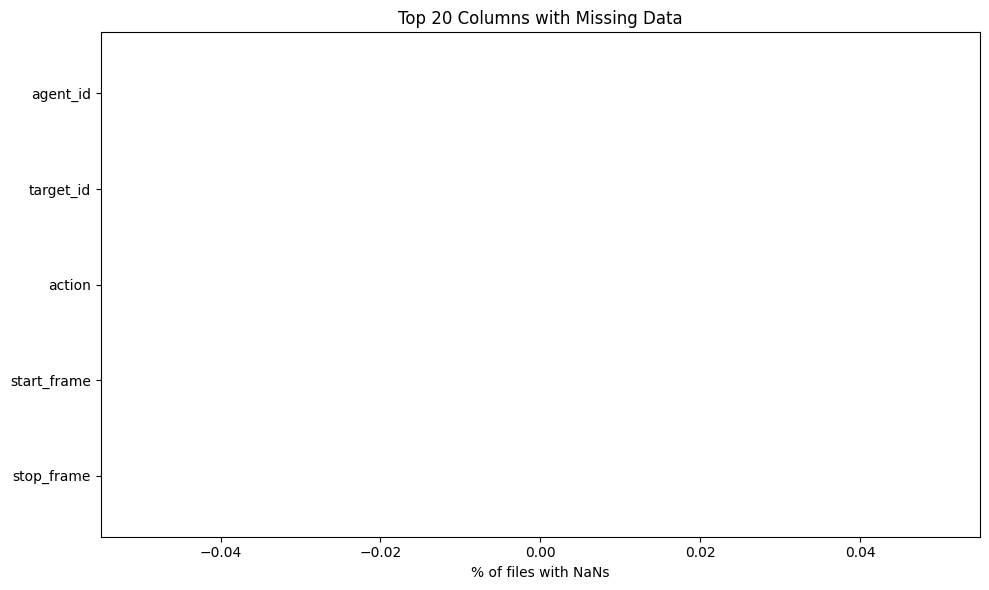

/tmp/ipykernel_13/2601261557.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


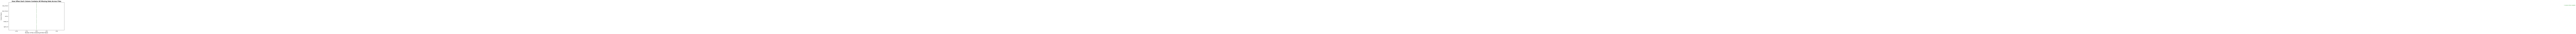

In [24]:
column_summary = summarize_parquet_columns("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")

print(column_summary.info())
print(column_summary.head(10))

# A summary of the structure of the competitions stock annotation files
column_summary_visuals(column_summary)

Found 847 parquet files in /kaggle/input/fixed-merged-files/annotated_fixed


Processing parquet files to count column occurrence:   0%|          | 0/847 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   63 non-null     object 
 1   file_count                    63 non-null     int64  
 2   any_null_value_file_count     63 non-null     int64  
 3   all_null_values_file_count    63 non-null     int64  
 4   percent_files_with_any_nulls  63 non-null     float64
 5   percent_files_with_all_nulls  63 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.1+ KB
None
                   column_name  file_count  any_null_value_file_count  \
0                       action         847                        847   
1              tail_midpoint_x         847                        847   
2               hindpaw_left_y         847                        847   
3    headpiece_topfrontright_y         847                        8

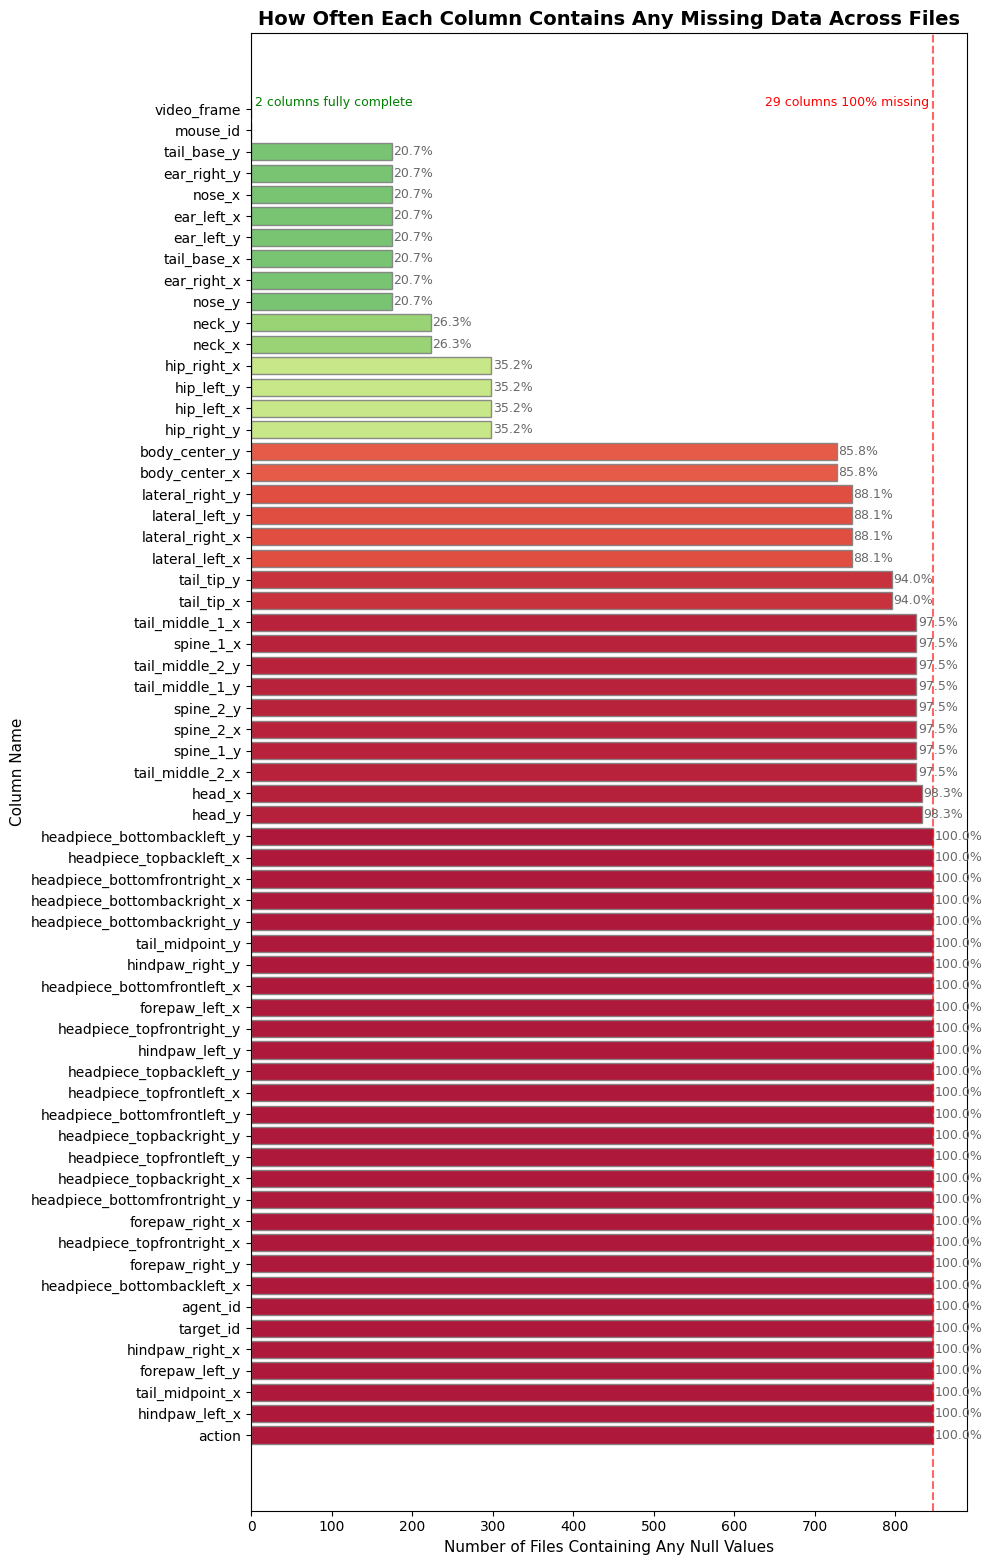

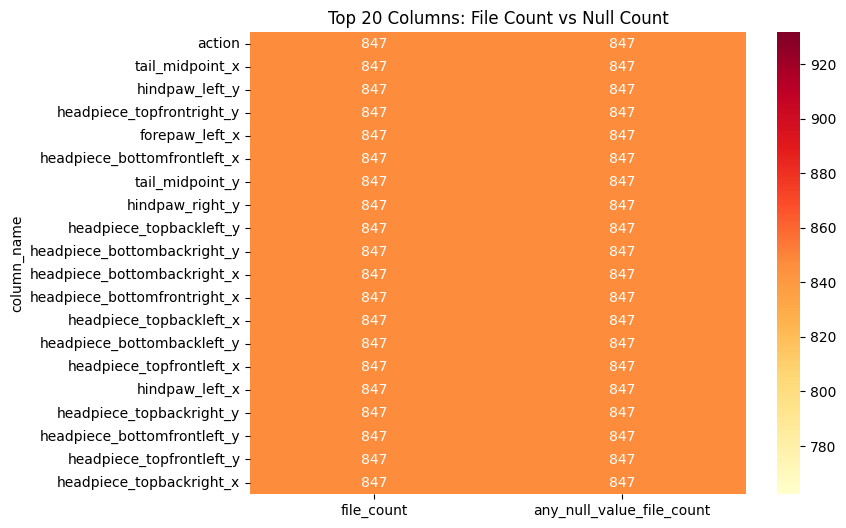

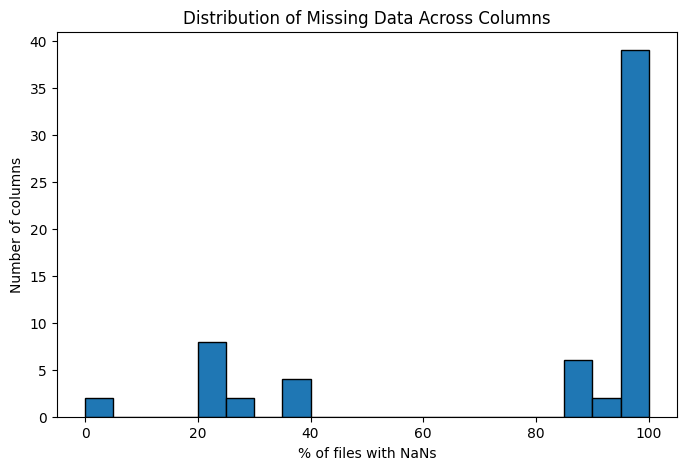

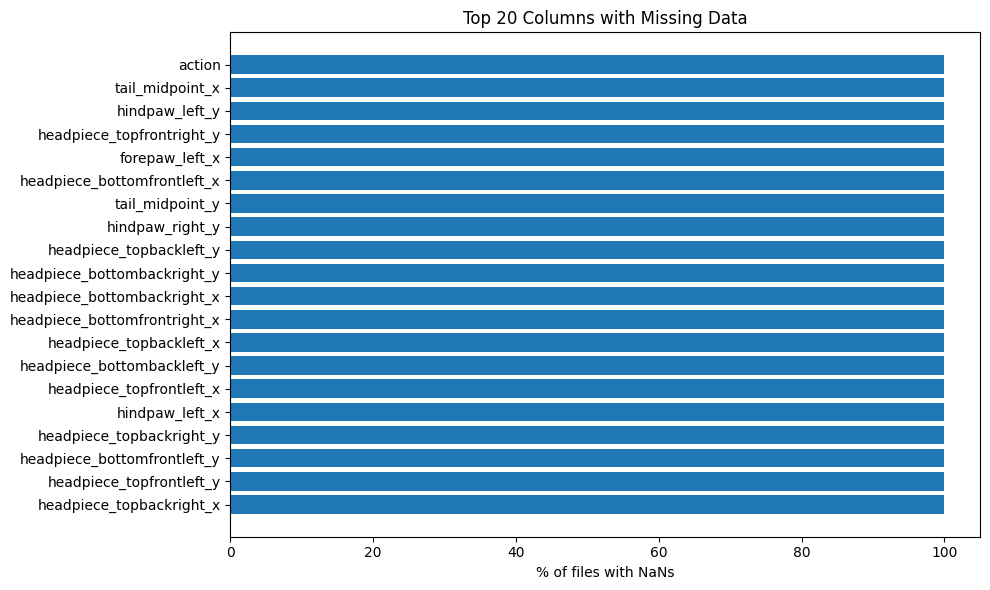

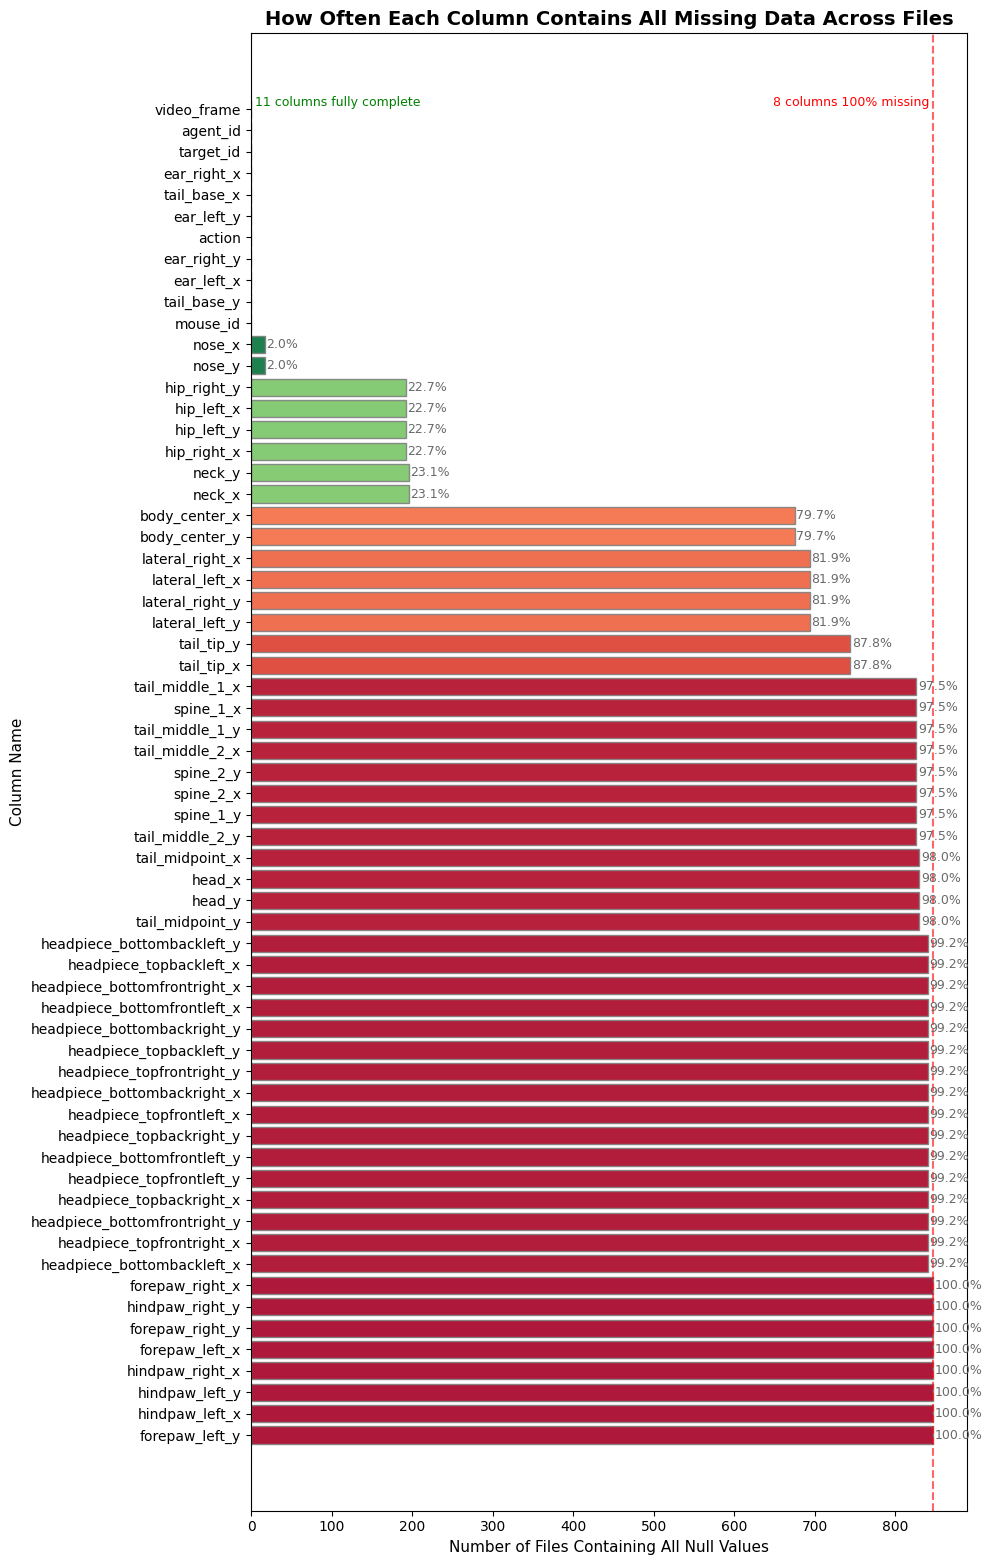

In [25]:
column_summary = summarize_parquet_columns("/kaggle/input/fixed-merged-files/annotated_fixed")

print(column_summary.info())
print(column_summary.head(10))

# A summary of the structure of the fixed annotated files
column_summary_visuals(column_summary)

Found 847 parquet files in /kaggle/input/fixed-merged-files/annotated_core


Processing parquet files to count column occurrence:   0%|          | 0/847 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   11 non-null     object 
 1   file_count                    11 non-null     int64  
 2   any_null_value_file_count     11 non-null     int64  
 3   all_null_values_file_count    11 non-null     int64  
 4   percent_files_with_any_nulls  11 non-null     float64
 5   percent_files_with_all_nulls  11 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 660.0+ bytes
None
    column_name  file_count  any_null_value_file_count  \
0      agent_id         847                        847   
1     target_id         847                        847   
2        action         847                        847   
3    ear_left_x         847                        175   
4    ear_left_y         847                        175   
5   ea

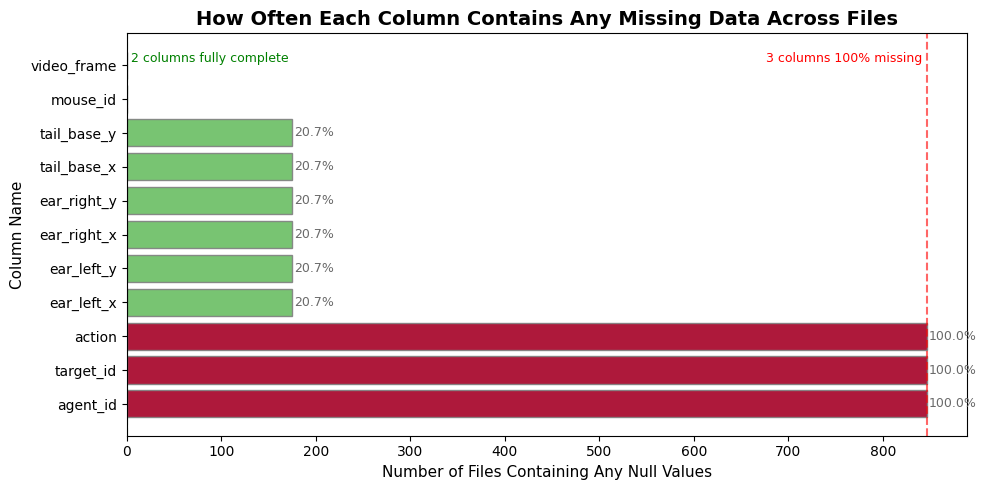

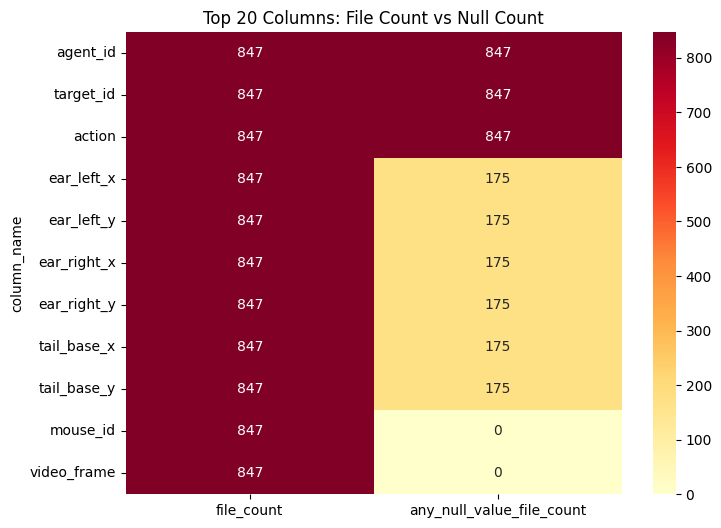

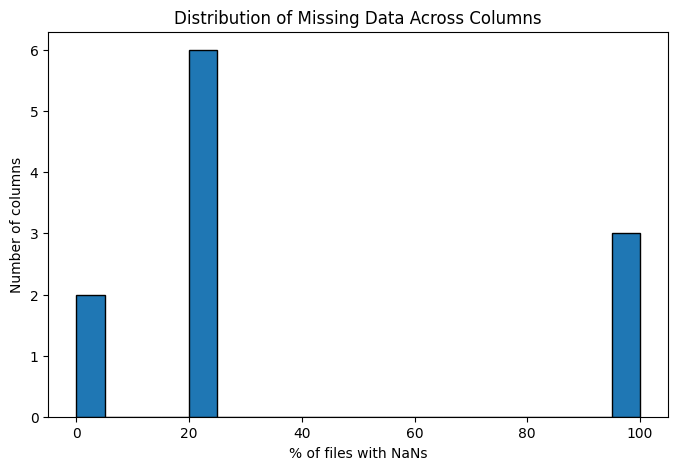

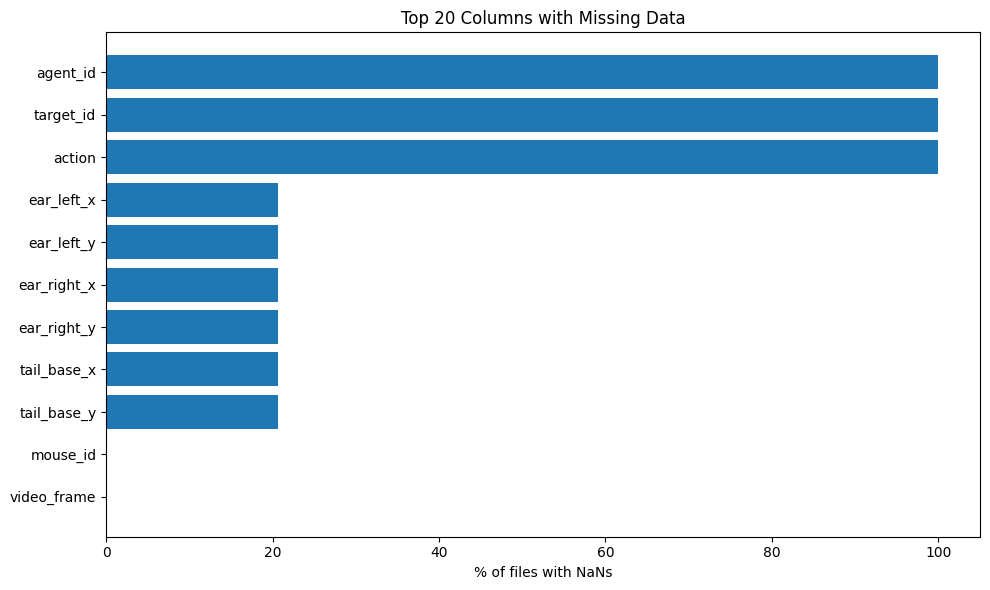

/tmp/ipykernel_13/2601261557.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


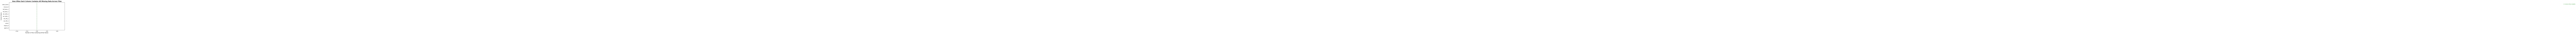

In [26]:
column_summary = summarize_parquet_columns("/kaggle/input/fixed-merged-files/annotated_core")

print(column_summary.info())
print(column_summary.head(15))

# A summary of the structure of the fixed core-feature only files
column_summary_visuals(column_summary)

Found 7942 parquet files in /kaggle/input/fixed-merged-files/tracking_core


Processing parquet files to count column occurrence:   0%|          | 0/7942 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   12 non-null     object 
 1   file_count                    12 non-null     int64  
 2   any_null_value_file_count     12 non-null     int64  
 3   all_null_values_file_count    12 non-null     int64  
 4   percent_files_with_any_nulls  12 non-null     float64
 5   percent_files_with_all_nulls  12 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 708.0+ bytes
None
     column_name  file_count  any_null_value_file_count  \
0  body_center_x        7942                          1   
1  body_center_y        7942                          1   
2     ear_left_x        7942                          1   
3     ear_left_y        7942                          1   
4    ear_right_x        7942                          1   


/tmp/ipykernel_13/507122947.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


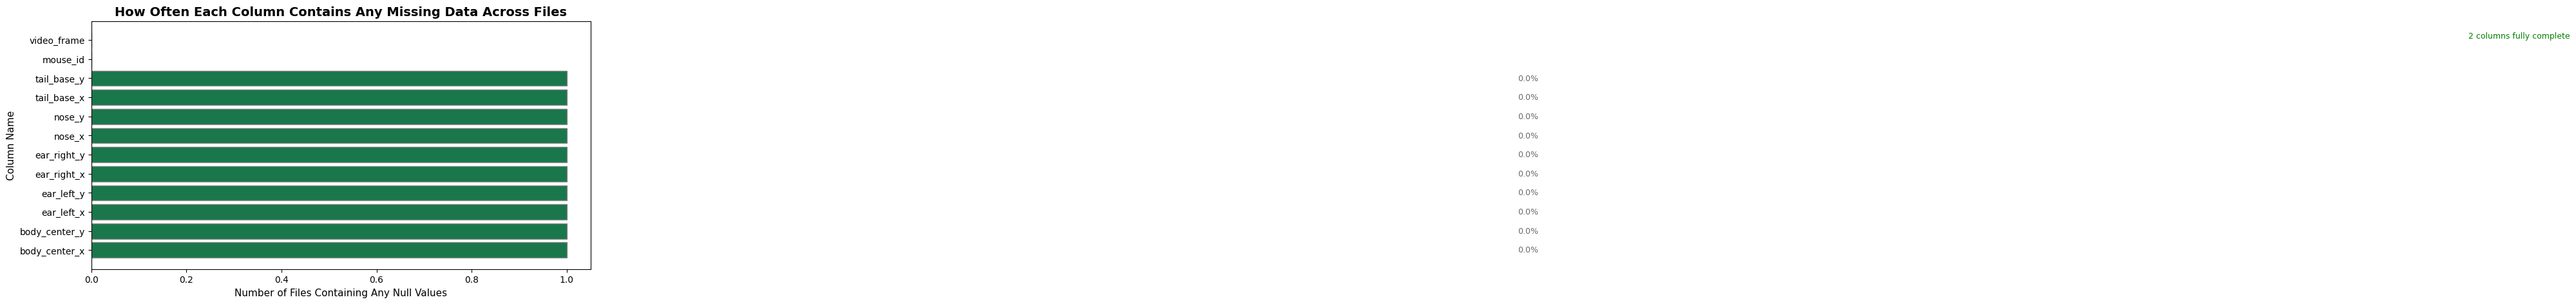

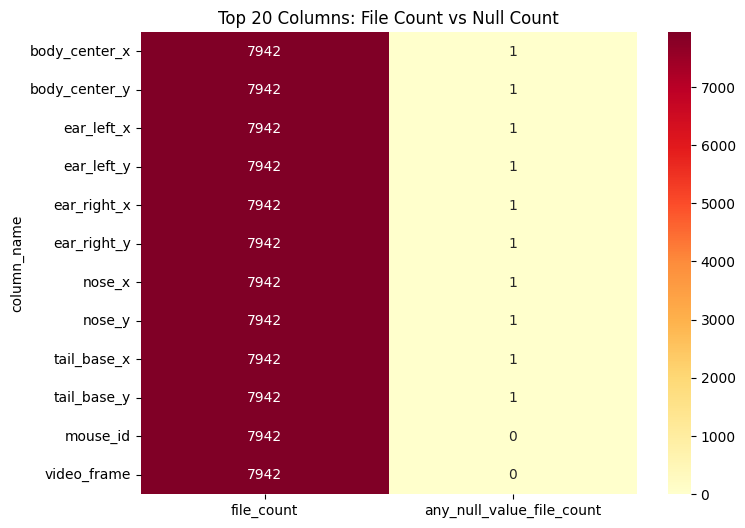

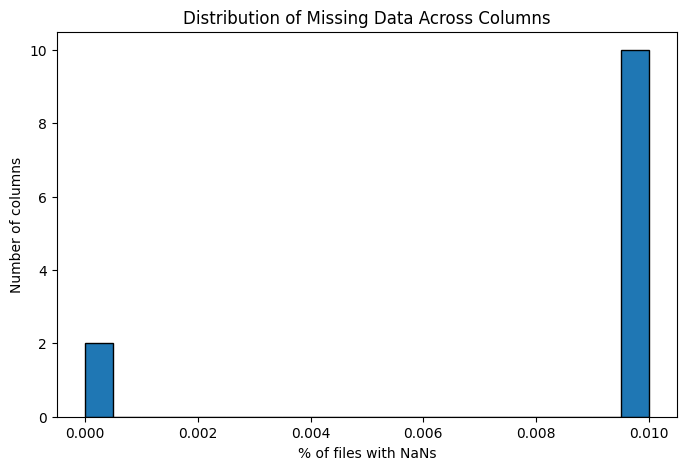

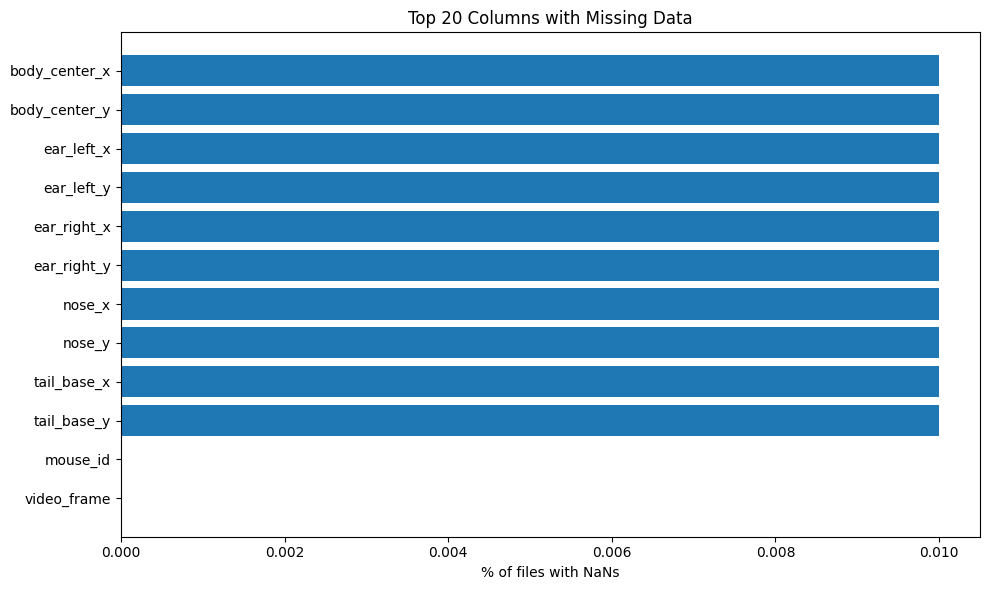

/tmp/ipykernel_13/2601261557.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


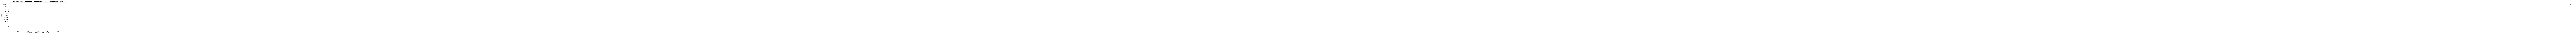

In [27]:
column_summary = summarize_parquet_columns("/kaggle/input/fixed-merged-files/tracking_core")

print(column_summary.info())
print(column_summary.head(10))

# A summary of the structure of the tracking files with core-features only
column_summary_visuals(column_summary)

Found 847 parquet files in /kaggle/input/annotated-core-bodyparts/feature-extraction


Processing parquet files to count column occurrence:   0%|          | 0/847 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   34 non-null     object 
 1   file_count                    34 non-null     int64  
 2   any_null_value_file_count     34 non-null     int64  
 3   all_null_values_file_count    34 non-null     int64  
 4   percent_files_with_any_nulls  34 non-null     float64
 5   percent_files_with_all_nulls  34 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.7+ KB
None
                  column_name  file_count  any_null_value_file_count  \
0               tail_midpoint         847                        847   
1     headpiece_topfrontright         847                        847   
2                forepaw_left         847                        847   
3   headpiece_bottomfrontleft         847                        847   

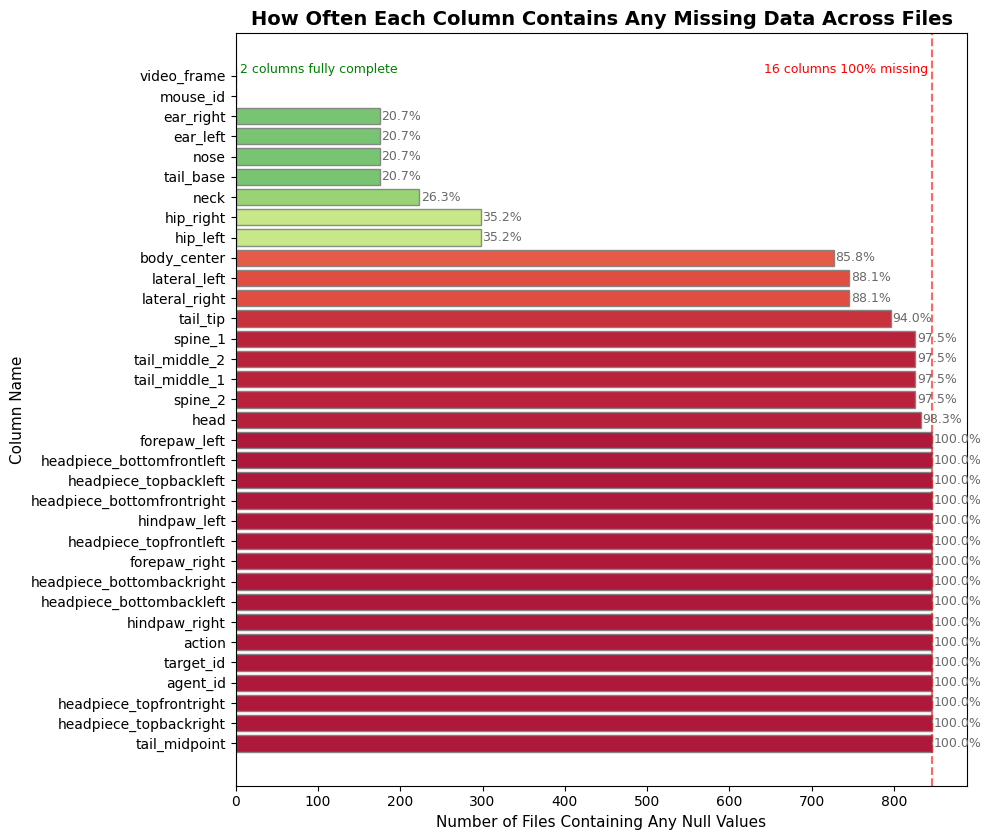

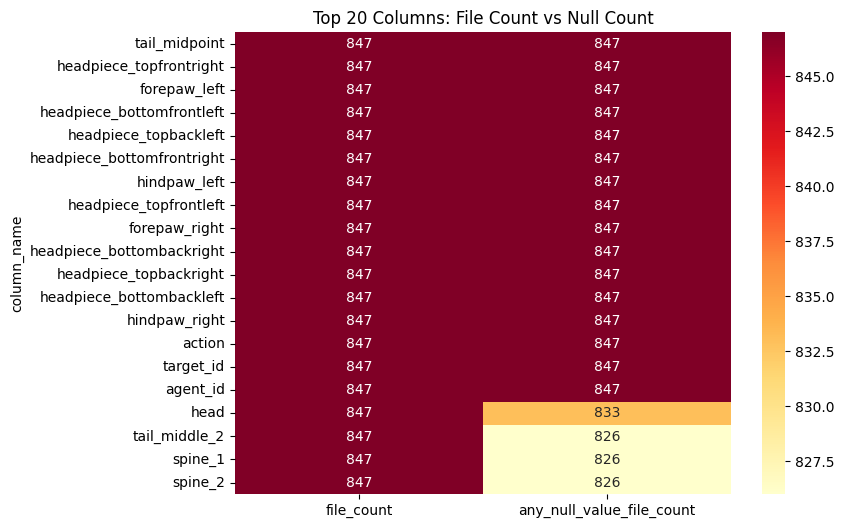

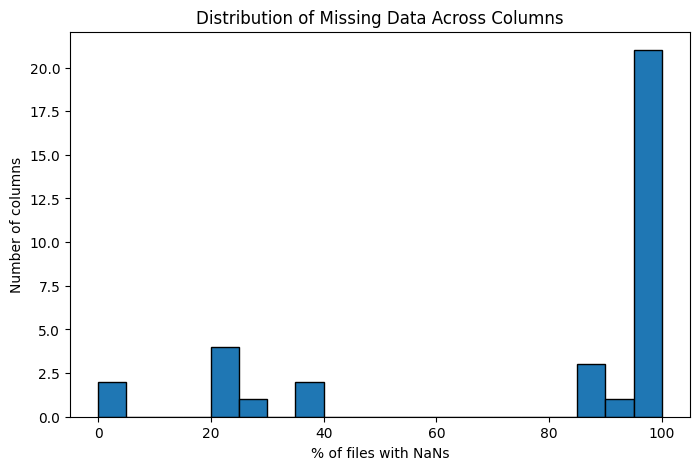

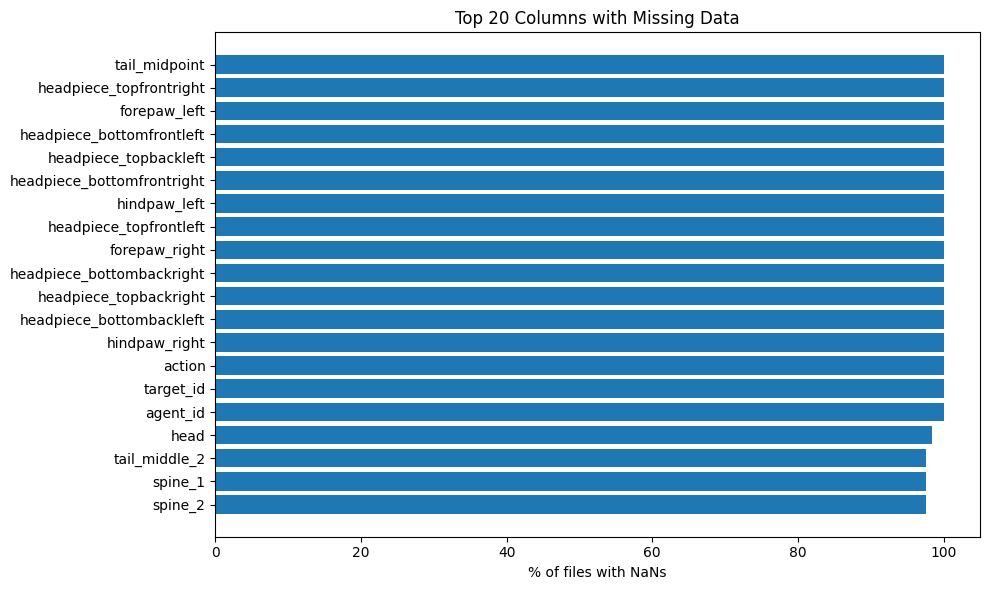

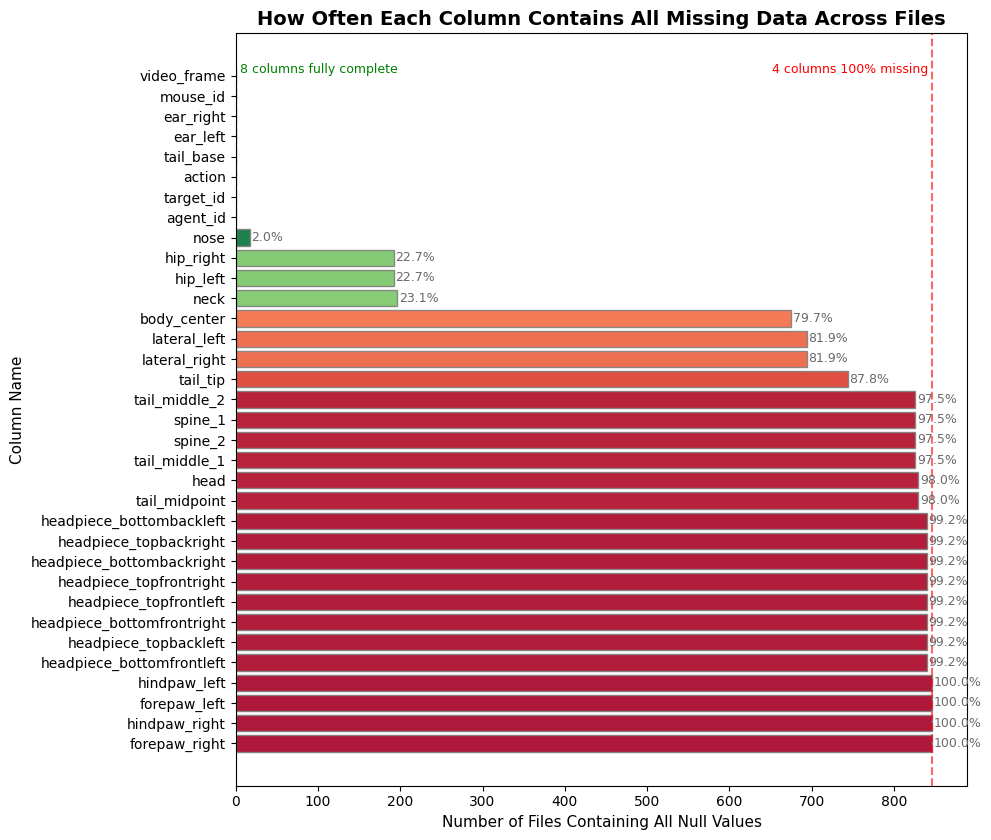

In [28]:
column_summary = summarize_parquet_columns("/kaggle/input/annotated-core-bodyparts/feature-extraction")

print(column_summary.info())
print(column_summary.head(10))
print(column_summary.tail(10))

# A summary of the structure of the cleaned 4 body part annotated files
column_summary_visuals(column_summary)

Found 830 parquet files in /kaggle/input/annotated-core-bodyparts/core-feature-extraction


Processing parquet files to count column occurrence:   0%|          | 0/830 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   column_name                   9 non-null      object 
 1   file_count                    9 non-null      int64  
 2   any_null_value_file_count     9 non-null      int64  
 3   all_null_values_file_count    9 non-null      int64  
 4   percent_files_with_any_nulls  9 non-null      float64
 5   percent_files_with_all_nulls  9 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 564.0+ bytes
None
   column_name  file_count  any_null_value_file_count  \
0     agent_id         830                        830   
1    target_id         830                        830   
2       action         830                        830   
3     ear_left         830                        158   
4    ear_right         830                        158   
5    tail_base

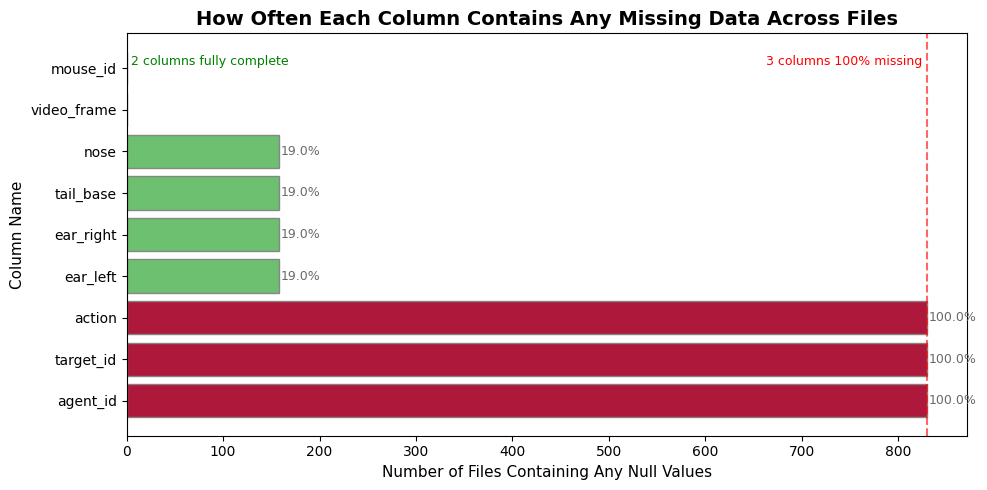

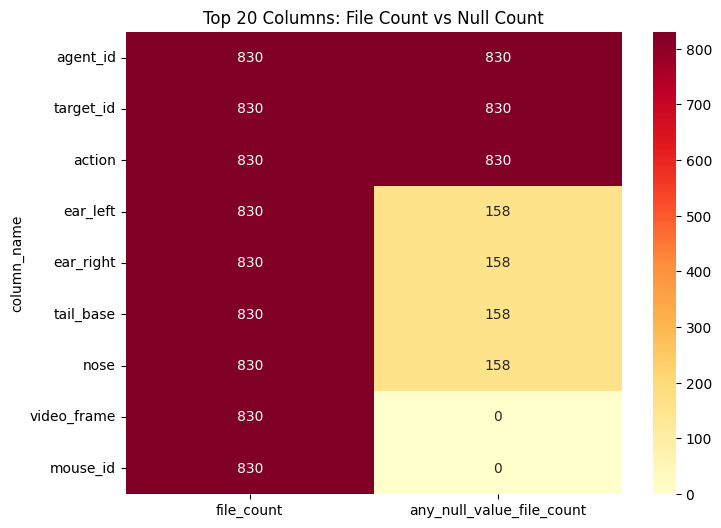

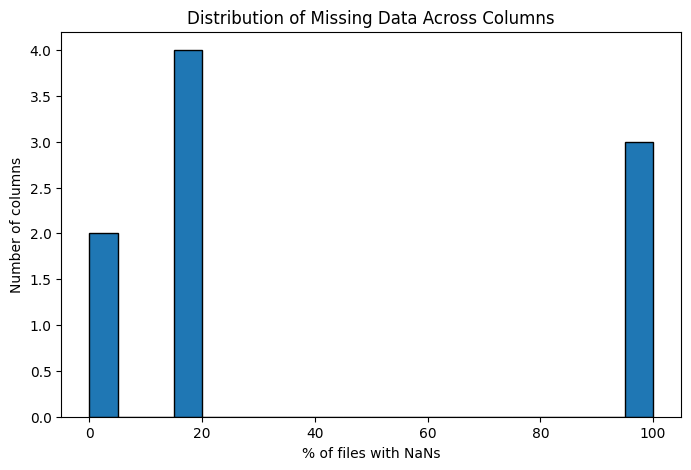

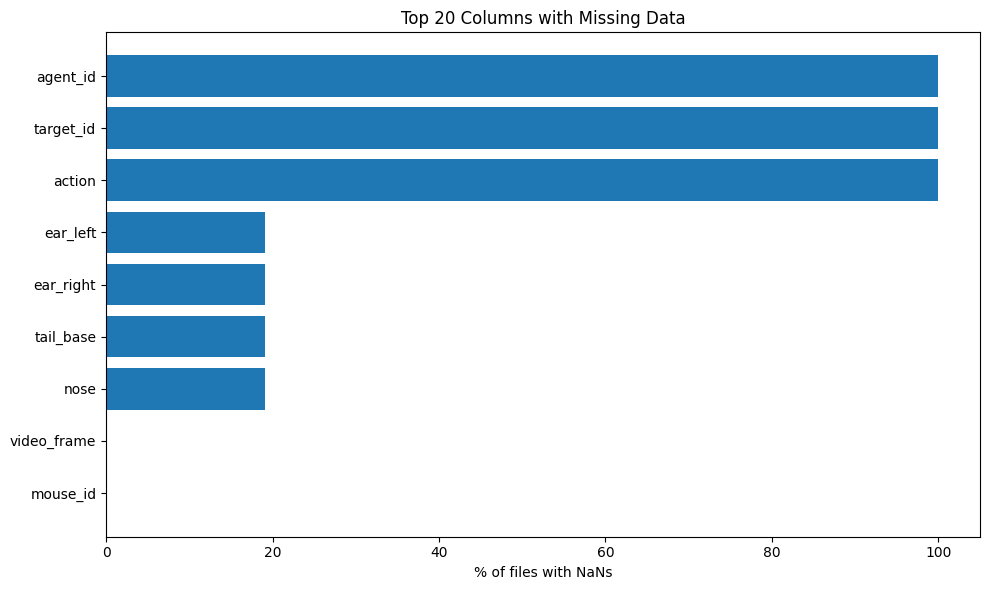

/tmp/ipykernel_13/2601261557.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


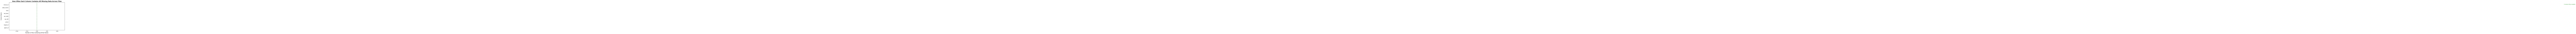

In [29]:
column_summary = summarize_parquet_columns("/kaggle/input/annotated-core-bodyparts/core-feature-extraction")

print(column_summary.info())
print(column_summary.head(10))

# A summary of the structure of the cleaned 3 body part annotated files
column_summary_visuals(column_summary)

In [30]:
print("All cells successfully run")

All cells successfully run
